In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

As in previous exercises, we will train a regression model to predict a person's weight from their height. The model is linear regression with one explanatory variable (weight) and an offset. The model is optimized under a least-squares loss. The variable $b$ contains the prediction targets (a vector of the length of the dataset) and the variable $A$ is the data matrix, containing (1) a column of ones and (2) a column with the explanatory variable.

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [3]:
print('(n, d) = ', A.shape)

(n, d) =  (10000, 2)


# Least Squares Estimation
Least squares estimation is one of the fundamental machine learning algorithms. Given an $ n \times d $ matrix $A$ and a $ n \times 1$ vector $b$, the goal is to find a vector $x \in \mathbb{R}^d$ which minimizes the objective function $$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

In this exercise, we will try to fit $x$ using Least Squares Estimation. 

One can see the function is $\mu$ strongly convex with $\mu = \lambda_{min}(\nabla^2 f(x)) = \frac{1}{n} \lambda_{min}(A^T A) $ and $L$ smooth with $L = \lambda_{max}(\nabla^2 f(x)) = \frac{1}{n} \lambda_{max}(A^T A)$, since here the Hessian matrix is constant, independent of $x$.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However when $n$ and $d$ are big (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using algorithms such as SGD, which consider a datapoint after the other.

In this lab, since $n$ and $d$ are small, and in order to exhibit the convergence rates seen in class, we start by computing $f(x^*)$. 

In [4]:
def full_objective(targets_b, data_A, params_x):
    # ***************************************************
    # calucalte objective
    # ***************************************************
    
    # computing the prediction
    y_pred = np.dot(data_A, params_x)
    # subtract the differences
    diff = np.subtract(y_pred, b)
    # return loss
    return np.square(diff).mean() /2
        
    
    return params_x

In [5]:
x_star = np.linalg.solve(A.T@A, A.T@b)
best_objective = full_objective(b, A, x_star)
print("f(x*) = ", best_objective)

f(x*) =  15.3858878688294


# Stochastic Gradient Descent

Please fill in the function `minibatch_gradient` below:

In [6]:
def minibatch_gradient(targets_b, data_A, params_x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param targets_b: a numpy array of shape (num_examples)
    :param data_A: a numpy array of shape (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    # ***************************************************
    # implement stochastic gradient computation. It's same as the gradient descent.
    # ***************************************************
    
    # computing the prediction
    h = np.dot(data_A, params_x)
    #  compute gradient
    grad = 2 * np.dot(data_A.T, (h - targets_b)) / len(targets_b)
        
    
    return grad

Verify empirically for a fixed parameter vector $x$ that the expected value of your `minibatch_gradient` function equals the full gradient. Validating this property for a mini-batch of size 1 is sufficient.

In [7]:
num_trials = 10
for i in range(num_trials):
    # Try different parameter vectors $x$
    x = np.random.rand(A.shape[1])

    # Compute the mean of all stochastic gradient for mini-batch size 1
    stochastic_gradients = []
    for i in range(len(b)):
        stochastic_gradients.append(minibatch_gradient(b[i:i+1], A[i:i+1, :], x))

    # Compute the full gradient
    full_gradient = minibatch_gradient(b, A, x)

    # Those should be the same on average
    assert np.allclose(np.mean(stochastic_gradients, axis=0), full_gradient)
    
print('Tests passed')

Tests passed


Now, implement stochastic gradient descent for Linear Least Squares, below.


In [8]:
def stochastic_gradient(targets_b, data_A, params_x, batch_size=1):
    """
    Compute a stochastic gradient
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    :param batch_size: integer: number of datapoints to compute the stochastic gradient from
    
    :return: gradient, numpy array of shape (num_features)
    """
    dataset_size = len(targets_b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(targets_b[indices], data_A[indices, :], params_x)

def stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate, 
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param initial_learning_rate: float
    :param decreasing_learning_rate: if set to true, the learning rate should decay as 1 / t 
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate
        
        # ***************************************************
        # implement stochastic gradient descent.
        # ***************************************************   
        x = x - lr * grad
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)
        xs.append(x)

        if iteration % 1000 == 0:
            print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Now it is time to test your optimizer with a naive step size with the example code below.

In [13]:
# Define the parameters of the algorithm.
max_iters = int(1e4)
gamma = 0.2   # this is totally arbitrary
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =    1686.91
SGD(1000/9999): objective =      37.05
SGD(2000/9999): objective =      18.92
SGD(3000/9999): objective =      23.37
SGD(4000/9999): objective =      34.94
SGD(5000/9999): objective =      21.37
SGD(6000/9999): objective =      19.71
SGD(7000/9999): objective =      29.40
SGD(8000/9999): objective =      19.22
SGD(9000/9999): objective =      18.05
SGD: execution time=49.739 seconds


#### Plotting the convergence

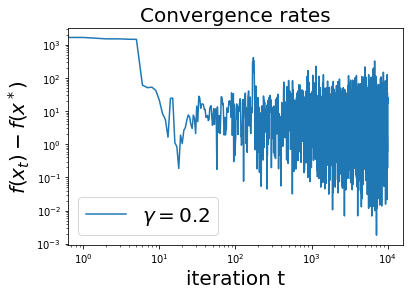

In [14]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

Note that using an arbitrary constant step size does not lead to appropriate convergence: the iterates "saturate" because of the stochastic noise and stop making progress at some point. We thus need to use more appropriate step sizes as given Theorem 5.1 and 5.2 from the lecture notes.

# Better Learning Rate

## Assuming bounded expected stochastic gradients
Assume we are moving in a bounded region $\|x\| \leq 25$ containing all iterates (and we assume $\|x-x^\star\| \leq 25$ as well, for simplicity). By $\nabla f(x) = \frac{1}{n}A^\top (Ax - b)$, one can see that $f$ is Lipschitz over that bounded region, with Lipschitz constant $\|\nabla f(x)\| \leq \frac{1}{n} (\|A^\top A\|\|x\| + \|A^\top b\|)$. We also know that $E\big[\|g_t\|\big | x_t\big]\ = \nabla f(x)$. So to find B such that  $E\big[\|g_t\|^2\big]\leq B^2$, we need to compute the Lipschitz constant.

In [12]:
# Define the parameters of the algorithm.
max_iters = int(1e4)  # 10 passes through the dataset

D = 25
B =  ((np.linalg.norm(A.T@A, 2) * 25) + np.linalg.norm(A.T@b, 2)) / len(A)
gamma = D / (B * np.sqrt(max_iters))
print(gamma)

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

0.0025119780701526005
SGD(0000/9999): objective =    2778.68
SGD(1000/9999): objective =      15.41
SGD(2000/9999): objective =      15.41
SGD(3000/9999): objective =      15.47
SGD(4000/9999): objective =      15.46
SGD(5000/9999): objective =      15.41
SGD(6000/9999): objective =      15.40
SGD(7000/9999): objective =      15.69
SGD(8000/9999): objective =      15.43
SGD(9000/9999): objective =      15.46
SGD: execution time=37.093 seconds


Time visualization with a better learning rate

#### Plotting the convergence

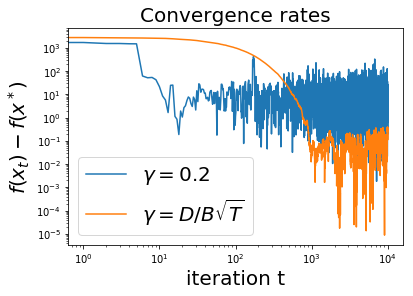

In [16]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.loglog(sgd_objectives_dec_gamma - best_objective, label = r'$\gamma = D / B \sqrt{T}$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## SGD using strong convexity

We didn't discuss this in the lecture, but the similarly to how regular GD performs better in the presence of strong convexity the same holds true for subgradient method and SGD.
For optimal performance the stepsize now has to decrease across iterations and is proportional to the strong convexity constant. (Both things have been already implemented for you.

In [17]:
# Define the parameters of the algorithm.
max_iters = int(1e4)

# You may use these results from last week
mu = np.linalg.norm(A.T@A, -2) / len(A)   
L = np.linalg.norm(A.T@A, 2) / len(A)

gamma0 = 2 / mu
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma_mu, sgd_xs_dec_gamma_mu = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =  582366.04
SGD(1000/9999): objective =      15.42
SGD(2000/9999): objective =      15.48
SGD(3000/9999): objective =      15.43
SGD(4000/9999): objective =      15.39
SGD(5000/9999): objective =      15.41
SGD(6000/9999): objective =      15.40
SGD(7000/9999): objective =      15.39
SGD(8000/9999): objective =      15.39
SGD(9000/9999): objective =      15.40
SGD: execution time=46.434 seconds


### Plotting the convergences

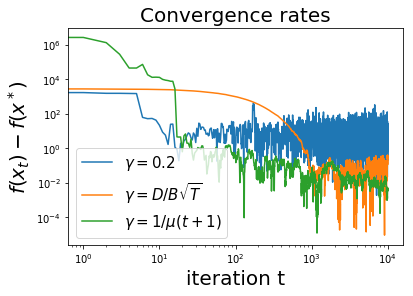

In [19]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.loglog(sgd_objectives_dec_gamma - best_objective, label = r'$\gamma = D/ B \sqrt{T}$')
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma = 1 / \mu (t + 1)$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

Check that the convergence rate for $\gamma_t \sim \frac{1}{t} $ is indeed $O(\frac{1}{t})$ as stated Theorem 5.1:

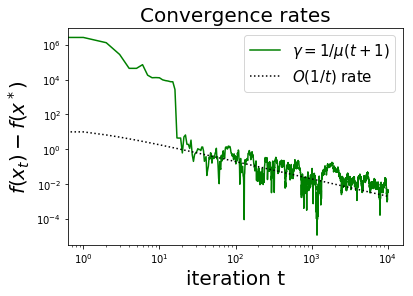

In [20]:
tab = np.arange(1, max_iters)

plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma = 1 / \mu (t + 1)$', color = 'g')
plt.loglog(20 / tab, label = r'$O(1 / t)$ rate', color = 'k', linestyle = 'dotted')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

In this last plot we clearly see the advantage of using log log plots. Indeed otherwise it is impossible to deduce anything: 

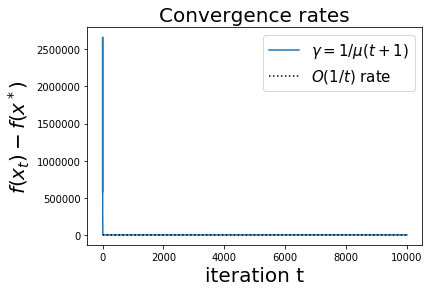

In [21]:
tab = np.arange(1, max_iters)

plt.title('Convergence rates', fontsize = 20)
plt.plot(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma = 1 / \mu (t + 1)$')
plt.plot(20 / tab, label = r'$O(1 / t)$ rate', color = 'k', linestyle = 'dotted')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

## Evolution of the objective function

Make sure to copy your code for the gradient descent implementation from lab03 into the file gradient_descent.py

Run the following code to compare SGD (with diffent stepsizes) and gradient descent with respect to the number of gradient computations needed per iteration (remember that gradient descent computes n gradients per iterations)

In [25]:
from gradient_descent import gradient_descent
T = 5 # number of full gradient computed

x_initial = np.zeros(A.shape[1])
gradient_objectives, gradient_xs = gradient_descent(b, A, x_initial, T, 1/(2 *L))
# Define the parameters of the algorithm.

max_iters = T * A.shape[0] # number of stochastic gradients which can be computed during the same time T (for batch size 1)
sgd_objectives_dec_gamma_mu, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, 1, max_iters, 2 / mu, decreasing_learning_rate=True)

Gradient Descent(0/4): objective=2792.2367127591674
Gradient Descent(1/4): objective=15.3858878688294
Gradient Descent(2/4): objective=15.3858878688294
Gradient Descent(3/4): objective=15.3858878688294
Gradient Descent(4/4): objective=15.3858878688294
SGD(0000/49999): objective =   18977.28
SGD(1000/49999): objective =      15.44
SGD(2000/49999): objective =      15.40
SGD(3000/49999): objective =      15.41
SGD(4000/49999): objective =      15.39
SGD(5000/49999): objective =      15.40
SGD(6000/49999): objective =      15.39
SGD(7000/49999): objective =      15.39
SGD(8000/49999): objective =      15.39
SGD(9000/49999): objective =      15.40
SGD(10000/49999): objective =      15.39
SGD(11000/49999): objective =      15.39
SGD(12000/49999): objective =      15.40
SGD(13000/49999): objective =      15.39
SGD(14000/49999): objective =      15.39
SGD(15000/49999): objective =      15.39
SGD(16000/49999): objective =      15.39
SGD(17000/49999): objective =      15.39
SGD(18000/49999): ob

Note that SGD takes a pretty long time to run because we ask it to compute the full objective at each iteration, this is not done in practice because it is computationally heavy.

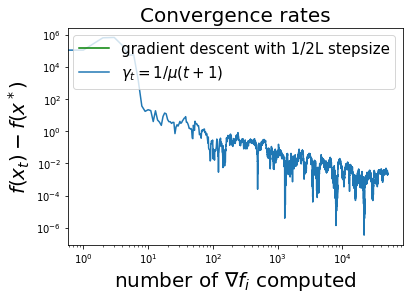

In [26]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(range(0,len(gradient_objectives)*10000,10000),
         gradient_objectives - best_objective,'g', label='gradient descent with 1/2L stepsize')
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma_t = 1 / \mu (t + 1)$')
plt.xlabel(r'number of $\nabla f_i$ computed'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

Note that SGD is much faster than GD at the beginning (GD will eventually become faster) and therefore makes it computationally more attractive.

# Loading more complex data
The data is taken from https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength 

In [27]:
data = np.loadtxt("Concrete_data.csv",delimiter=",")

A = data[:,:-1]
b = data[:,-1]
A, mean_A, std_A = standardize(A)

In [28]:
b.shape, A.shape

((1030,), (1030, 8))

In [29]:
x_star = np.linalg.solve(A.T@A, A.T@b)
best_objective = full_objective(b, A, x_star)
print('f(x*) = ', best_objective)

f(x*) =  695.0617890478906


# Running stochastic gradient descent

Test your SGD algorithm on the new dataset. Try different learning rates. Is the outcome very stable?

In [30]:
max_iters = int(1e4)

gamma =  0.01  # totally arbitrary      

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =     784.20
SGD(1000/9999): objective =     717.10
SGD(2000/9999): objective =     728.22
SGD(3000/9999): objective =     737.65
SGD(4000/9999): objective =     773.28
SGD(5000/9999): objective =     721.82
SGD(6000/9999): objective =     725.08
SGD(7000/9999): objective =     734.82
SGD(8000/9999): objective =     778.67
SGD(9000/9999): objective =     743.97
SGD: execution time=12.517 seconds


# Plotting the Evolution of the Objective Function

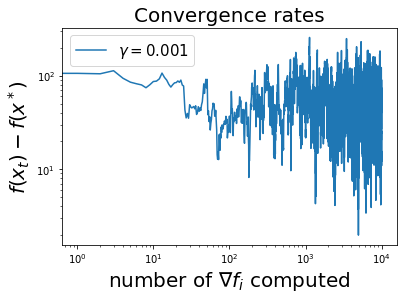

In [31]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.001$')
plt.xlabel(r'number of $\nabla f_i$ computed'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

# Projected Stochastic Gradient Descant

To avoid $x$ becoming too big, we can perform constrained optimization by projecting x onto an $\text{L}_2$ ball at each iteration, thus limiting the norm of $x$.

Fill in the `projection` function below, which projects x onto an L2-ball:
(make sure the optimum is inside the l2-ball by choosing an appropriate radius)

In [33]:
# use norm of xstar as the radius
l2_ball_radius = np.linalg.norm(x_star) 
def projection(x):
    """project x onto an l2-ball"""
    # ***************************************************
    # compute the projection of x onto the l2-ball
    # ***************************************************
    return min((l2_ball_radius / np.linalg.norm(x, 2)), 1) * x;

Fill in the `projected_stochastic_gradient_descent` function below:<br>
(Hint: it is the same as stochastic_gradient_descent but with an extra step in the loop)

In [34]:
def projected_stochastic_gradient_descent(
        b, 
        A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate,
        decreasing_learning_rate = False, 
        projection_fn = lambda x: x):

    """Projected gradient descent."""
    # ***************************************************
    # implement stochastic gradient descent.
    # ***************************************************
    
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(b, A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate
        
        # ***************************************************
        # implement stochastic gradient descent.
        # ***************************************************   
        
        # update x
        x = x - lr * grad
        # project x
        x = projection_fn(x)
        
        #calculate objective
        objective = full_objective(b, A, x)
        
        # save objectives and xs
        objectives.append(objective)
        xs.append(x)

        if iteration % 1000 == 0:
            print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=objective))
            
    return objectives, xs

Test your projected SGD function

In [38]:
max_iters = int(1e4)

gamma =  0.001 

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
psgd_objectives, psgd_xs = projected_stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma,
    projection_fn=projection)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =     781.03
SGD(1000/9999): objective =     702.32
SGD(2000/9999): objective =     703.23
SGD(3000/9999): objective =     700.22
SGD(4000/9999): objective =     706.34
SGD(5000/9999): objective =     703.39
SGD(6000/9999): objective =     696.62
SGD(7000/9999): objective =     698.49
SGD(8000/9999): objective =     700.77
SGD(9000/9999): objective =     702.22
SGD: execution time=17.842 seconds


Plot the error

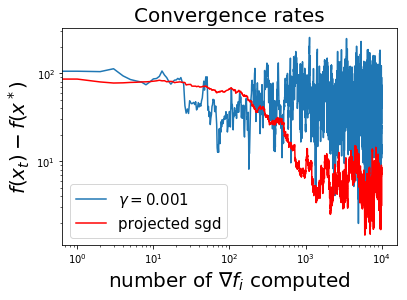

In [39]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.001$')
plt.loglog(psgd_objectives - best_objective,'r', label='projected sgd')
plt.xlabel(r'number of $\nabla f_i$ computed'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()